 # Creating New data set

In [179]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, Polygon
from pyproj import CRS
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
import folium
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMap#, heat_map_withtime, HeatMapWithTime
from folium.plugins.heat_map_withtime import HeatMapWithTime
from sklearn.neighbors import KernelDensity

In [180]:
# Load the dataset into a DataFrame
df = pd.read_csv('../data/kc_house_data.csv')

In [181]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

importing relevent shapefiles

In [182]:
# Read in shp
king_boundary = gpd.read_file('Metropolitan_King_County_Council___kccdst_area_copy/Metropolitan_King_County_Council___kccdst_area.shp')
School_districts_df = gpd.read_file('School_Districts_in_King_County___schdst_area/School_Districts_in_King_County___schdst_area.shp')
WADOH_df = gpd.read_file('WADOH_Environmental_Health_Disparities_Index_Calculated_for_King_County___wadohehdindex_area/WADOH_Environmental_Health_Disparities_Index_Calculated_for_King_County___wadohehdindex_area.shp')
income_df_i = gpd.read_file('Basic_demographics_by_census_tracts_in_King_County_-_selected_categories___demographic_base_area_esj/Basic_demographics_by_census_tracts_in_King_County_-_selected_categories___demographic_base_area_esj.shp')


Converting df to gdf

In [7]:
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df['long'], df['lat']), 
                       crs= CRS.from_epsg(4326))

Spatially joinning dataframes

In [123]:
# gdf_final = gpd.sjoin(gdf, School_districts_df, how='inner')

In [10]:
# Checking length of DataFrame
len(gdf_final)

29213

# Cleaning WADOH_df before spatially joinning
WADOH_df contains lots of excess data that can potentially cause errors
- to prevent this I will be removing excess columns

This data set contains 193 different columns, I used information on the following websites to help select which data to keep.
Furthermore when the names of the columns where changed so they do not match the labels indicated online.
- https://doh.wa.gov/data-and-statistical-reports/washington-tracking-network-wtn/washington-environmental-health-disparities-map
- https://doh.wa.gov/sites/default/files/2022-07/311-013_EHD-Map-Report-Infosheet.pdf?uid=6421fa4666531
- https://doh.wa.gov/sites/default/files/2022-07/311-011-EHD-Map-Tech-Report_0.pdf?uid=6421fa4666f2a

- For traffic data I am using decile as that is the Decile ranking of proximity to heavy traffic roadway
- For Toxic release I am using count as that shows that actual value of toxic releaase in that area
- Hazardous waste I am using decile as that is the decile ranking of proximity to hazardous water treatment storage


In [97]:
WADOH_df.columns

Index(['OBJECTID_1', 'GEO_ID_TRT', 'FEATURE_ID', 'TRACT_LBL', 'TRACT_STR',
       'TRACT_INT', 'TRACT_FLT', 'TRACT_DEL', 'TRTLABEL_F', 'TRTLABEL_C',
       ...
       'sen_pop_di', 'socio_eco_', 'socio_deci', 'socio_perc', 'socio_quin',
       'socio_diff', 'ObjectID', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=193)

In [139]:
# Creating a list of columns to keep
keep_wadoh = ['traffic_de','toxic_rele','hazardou_2', 'geometry']
env_df = WADOH_df[keep_wadoh]
env_df

,traffic_de,toxic_rele,hazardou_2,geometry
0,10.0,5604.022500,3.0,"POLYGON ((-122.28419 47.73361, -122.28417 47.7..."
1,8.0,6765.634069,3.0,"POLYGON ((-122.30195 47.73383, -122.30058 47.7..."
2,10.0,7681.130250,4.0,"POLYGON ((-122.32359 47.73405, -122.32359 47.7..."
3,9.0,8400.088589,5.0,"POLYGON ((-122.34510 47.73413, -122.34509 47.7..."
4,6.0,9171.090649,5.0,"POLYGON ((-122.34498 47.72324, -122.34497 47.7..."
...,...,...,...,...
393,7.0,2067.674744,1.0,"POLYGON ((-121.25349 47.53323, -121.25362 47.5..."
394,5.0,2039.453458,1.0,"POLYGON ((-121.78607 47.52523, -121.78605 47.5..."
395,6.0,1643.401265,1.0,"POLYGON ((-121.69417 47.47968, -121.69398 47.4..."
396,5.0,823.898408,1.0,"POLYGON ((-121.25349 47.53323, -121.25349 47.5..."


<Axes: >

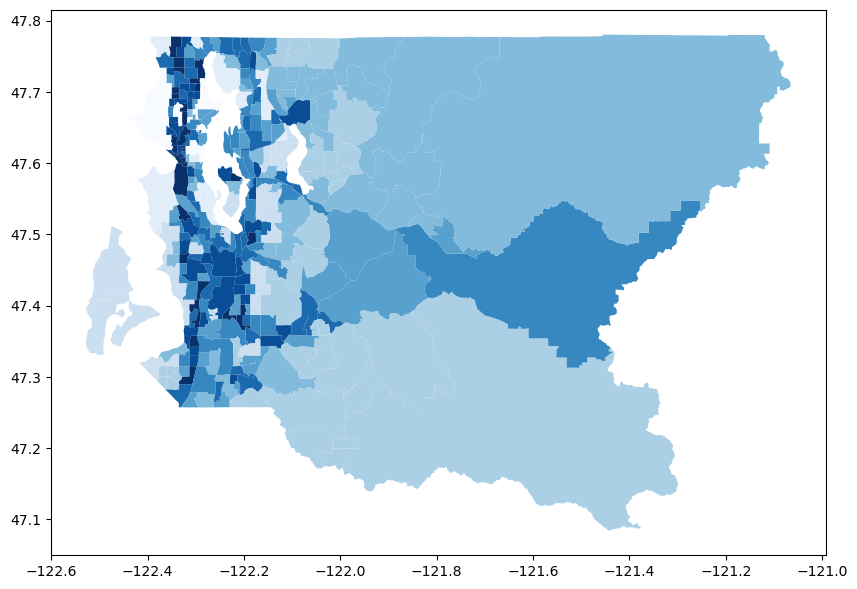

In [131]:
# set figure size
fig, ax = plt.subplots(figsize=(10, 10))

env_df.plot(ax=ax,column='traffic_de', cmap='Blues',)

In [150]:
income_df = income_df_i.drop(columns=['OBJECTID','GEO_ID_TRT'])
income_df

,MHHI1,geometry
0,48002.0,"POLYGON ((-122.28419 47.73361, -122.28417 47.7..."
1,63727.0,"POLYGON ((-122.30195 47.73383, -122.30058 47.7..."
2,65781.0,"POLYGON ((-122.32359 47.73405, -122.32359 47.7..."
3,32196.0,"POLYGON ((-122.34510 47.73413, -122.34509 47.7..."
4,61184.0,"POLYGON ((-122.34498 47.72324, -122.34497 47.7..."
...,...,...
393,99543.0,"POLYGON ((-121.25349 47.53323, -121.25362 47.5..."
394,84837.0,"POLYGON ((-121.78607 47.52523, -121.78605 47.5..."
395,73241.0,"POLYGON ((-121.69417 47.47968, -121.69398 47.4..."
396,88409.0,"POLYGON ((-121.25349 47.53323, -121.25349 47.5..."


In [134]:
SD_df = School_districts_df.drop(columns=['OBJECTID','Shape_Leng', 'Shape_Area'])
SD_df

,SCHDST,NAME,DSTNUM,geometry
0,1,Seattle,17001,"MULTIPOLYGON (((-122.40324 47.66637, -122.4028..."
1,210,Federal Way,17210,"POLYGON ((-122.29057 47.39374, -122.29039 47.3..."
2,216,Enumclaw,17216,"POLYGON ((-121.84898 47.34708, -121.84908 47.3..."
3,400,Mercer Island,17400,"POLYGON ((-122.24475 47.59601, -122.24461 47.5..."
4,401,Highline,17401,"POLYGON ((-122.35853 47.51553, -122.35851 47.5..."
5,402,Vashon Island,17402,"POLYGON ((-122.47330 47.51112, -122.47302 47.5..."
6,403,Renton,17403,"POLYGON ((-122.19290 47.54932, -122.19281 47.5..."
7,404,Skykomish,17404,"POLYGON ((-121.43171 47.78048, -121.41064 47.7..."
8,405,Bellevue,17405,"POLYGON ((-122.21511 47.65306, -122.21511 47.6..."
9,406,Tukwila,17406,"POLYGON ((-122.27170 47.49817, -122.27149 47.4..."


In [172]:
#1
gdf_1 = gpd.sjoin(gdf, income_df, how='inner')
# gdf_1.drop('index_left', axis=1, inplace=True)
gdf_1.drop('index_right', axis=1, inplace=True)
#2
gdf_2 = gpd.sjoin(gdf_1, env_df, how='inner')
gdf_2.drop('index_right', axis=1, inplace=True)
#3
gdf_3 = gpd.sjoin(gdf_2, SD_df, how='inner')
gdf_3.drop('index_right', axis=1, inplace=True)

In [174]:
gdf_3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 29211 entries, 0 to 29389
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             29211 non-null  int64   
 1   date           29211 non-null  object  
 2   price          29211 non-null  float64 
 3   bedrooms       29211 non-null  int64   
 4   bathrooms      29211 non-null  float64 
 5   sqft_living    29211 non-null  int64   
 6   sqft_lot       29211 non-null  int64   
 7   floors         29211 non-null  float64 
 8   waterfront     29211 non-null  object  
 9   greenbelt      29211 non-null  object  
 10  nuisance       29211 non-null  object  
 11  view           29211 non-null  object  
 12  condition      29211 non-null  object  
 13  grade          29211 non-null  object  
 14  heat_source    29182 non-null  object  
 15  sewer_system   29198 non-null  object  
 16  sqft_above     29211 non-null  int64   
 17  sqft_basement  29211 no

In [178]:
gdf_3.to_csv('updated_housing.csv', index=False)